In [6]:
#-- Draw anomalies for 1997 and 1998
# idir = "/g/data/p66/ars599/mo_gc3/cq317/apm.pp/netCDF/20*.nc"
%matplotlib inline
import os
import pandas as pd
import xarray as xr
from netCDF4 import  num2date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from mpl_toolkits.basemap import Basemap

import os
os.getcwd()

%cd /home/599/ars599/Documents/a10/


/home/599/ars599/Documents/a10


In [9]:
file1 = 'sst_HI-00_output.nc'
file2 = 'sst_HI-02_output.nc'
sst1   = xr.open_dataset(file1)['fld_s00i024']
sst2   = xr.open_dataset(file2)['fld_s00i024']

<xarray.DataArray 'fld_s00i024' (time: 600, lat: 145, lon: 192)>
[16704000 values with dtype=float32]
Coordinates:
  * time              (time) datetime64[ns] 1885-06-16 ... 1874-07-16T12:00:00
  * lat               (lat) float64 -90.0 -88.75 -87.5 ... 87.5 88.75 90.0
  * lon               (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    surface_altitude  (time, lat, lon) float64 ...
    height            float64 ...
    height_0          float64 ...
    pseudo_level_1    int32 ...
Attributes:
    standard_name:    surface_temperature
    long_name:        SURFACE TEMPERATURE AFTER TIMESTEP
    units:            K
    um_stash_source:  m01s00i024
    cell_methods:     time: mean
    grid_mapping:     latitude_longitude

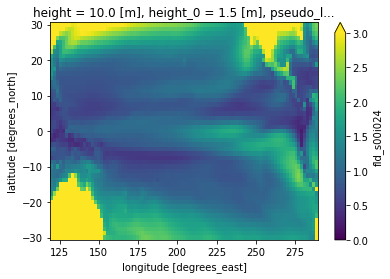

In [52]:
latS = -30.
latN = 30.
lonW = 120.
lonE = 290

sst_diff = sst1.sel(time='1885-06-16') - sst2.sel(time='1885-06-16')
sst2.sel(lat=slice(latS, latN), lon=slice(lonW, lonE)).std(axis=0).plot(vmin=0,vmax=3)

/local/p66/ars599/tmp/ipykernel_2673968/4082565194.py:8: UserWarning: linewidths is ignored by contourf
  plt.contourf(sst_diff.lon, sst_diff.lat,


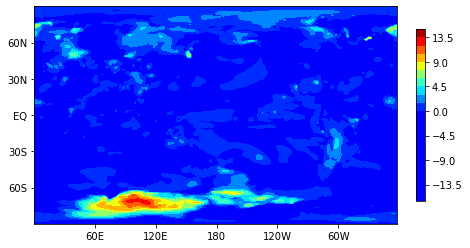

In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr

levs = np.arange(16, 29, 0.05)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
cm = clr.LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
fig = plt.figure(figsize = (7, 4))
plt.contourf(sst_diff.lon, sst_diff.lat,
             sst_diff.squeeze(),
             levels = 20, linewidths = 1, vmin = 0, cmap = cm)
plt.xticks(np.arange(60, 350, 60), ['60E', '120E', '180', '120W', '60W'])
plt.yticks(np.arange(-60, 90, 30), ['60S', '30S', 'EQ', '30N', '60N'])
cbar=plt.colorbar(fraction=0.022)
plt.show()

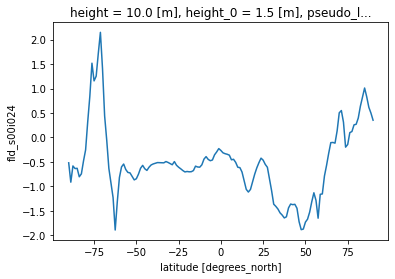

In [38]:
sst_time_and_zonal_mean = sst_diff.mean(dim=('time', 'lon'))
sst_time_and_zonal_mean.plot()

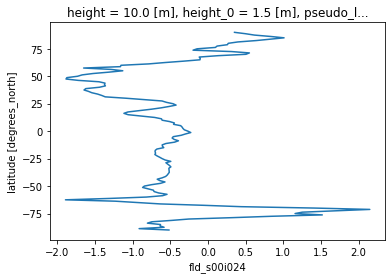

In [53]:
# some might prefer to have lat on the y axis
sst_time_and_zonal_mean.plot(y='lat')

In [54]:
# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     lon=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)

# -- correlation and covariance
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

/local/p66/ars599/tmp/ipykernel_2673968/1145530320.py:9: UserWarning: linewidths is ignored by contourf
  plt.contourf(sst_cor.lon, sst_cor.lat,


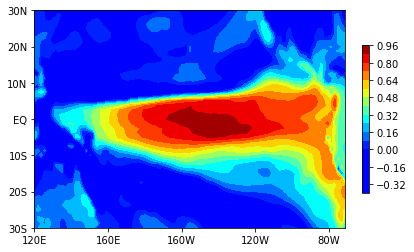

In [98]:
sst_clim = sst1.groupby('time.month').mean(dim='time')
sst_anom = sst1.groupby('time.month') - sst_clim
sst_anom = sst_anom.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))

# calculate n34 and correlation plot
n34 = wgt_areaave(sst_anom, -5, 5, 190, 240)
sst_cor = corrrelation(sst_anom, n34, dims='time')

plt.contourf(sst_cor.lon, sst_cor.lat,
             sst_cor,
             levels = 20, linewidths = 1, vmin = 0, cmap = cm)
plt.xticks(np.arange(120, 320, 40), ['120E', '160E', '160W', '120W', '80W'])
plt.yticks(np.arange(-30, 40, 10), ['30S', '20S', '10S', 'EQ', '10N', '20N', '30N'])
cbar=plt.colorbar(fraction=0.022)
plt.show()


/local/p66/ars599/tmp/ipykernel_2673968/1483726570.py:9: UserWarning: linewidths is ignored by contourf
  plt.contourf(sst_cor.lon, sst_cor.lat,


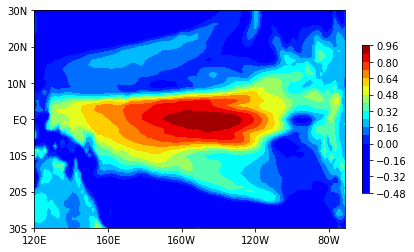

In [100]:
sst_clim = sst2.groupby('time.month').mean(dim='time')
sst_anom = sst2.groupby('time.month') - sst_clim
sst_anom = sst_anom.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))

# calculate n34 and correlation plot
n34 = wgt_areaave(sst_anom, -5, 5, 190, 240)
sst_cor = corrrelation(sst_anom, n34, dims='time')

plt.contourf(sst_cor.lon, sst_cor.lat,
             sst_cor,
             levels = 20, linewidths = 1, vmin = 0, cmap = cm)
plt.xticks(np.arange(120, 320, 40), ['120E', '160E', '160W', '120W', '80W'])
plt.yticks(np.arange(-30, 40, 10), ['30S', '20S', '10S', 'EQ', '10N', '20N', '30N'])
cbar=plt.colorbar(fraction=0.022)
plt.show()


Text(0.5, 1.0, 'Correlation btw. global SST Anomaly and SST Anomaly at one point')

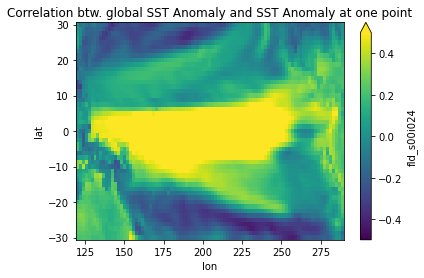

In [103]:
sst_clim = sst2.groupby('time.month').mean(dim='time')
sst_anom = sst2.groupby('time.month') - sst_clim
sst_anom = sst_anom.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))

# calculate n34 and correlation plot
n34 = wgt_areaave(sst_anom, -5, 5, 190, 240)
sst_cor = corrrelation(sst_anom, n34, dims='time')
pc = sst_cor.plot(vmin=-.5,vmax=.5)
pc.axes.set_title('Correlation btw. global SST Anomaly and SST Anomaly at one point')
